In [43]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [44]:
%matplotlib inline

from session.sessions import selected_009266, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
np.set_printoptions(suppress=True)

In [45]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Session data

In [46]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [47]:
session = sessions[0]

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
aeps_events = session_data['aeps_events']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'009266_hippoSIT_2023-04-17_17-04-17'

### Choose target selective units

In [48]:
offset    = 7.25
bin_count = 30

In [53]:
tgt_units       = []
idxs_succ       = np.where(tgt_matrix[:, 4] == 1)[0]
tgt_succ_times  = tl[tgt_matrix[idxs_succ][:, 0]][:, 0]
tgt_all_times   = tl[tgt_matrix[:, 0]][:, 0]

for unit_name in unit_names:
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
    
    # based on success trials
    strain = spike_times[unit_name]
    bins, counts_enter = get_spike_counts(strain, tgt_all_times, hw=offset, bin_count=bin_count)
    zero_bin_idx = len(bins[bins < 0]) - 1

    if counts_enter[zero_bin_idx] > shuffled[zero_bin_idx][3]: #or \
        #counts_enter[zero_bin_idx + 1] > shuffled[zero_bin_idx + 1][3]:
        tgt_units.append(unit_name)
        
print("%d units selected" % len(tgt_units))

11 units selected


###  Mean population response (all / diff brain areas)

In [54]:
# unit state before entering
# unit     = '1-10'
# t_before = 2  # seconds
# s_rate   = 100
# i_rate   = single_units[unit]

# idxs_before_low  = []
# idxs_before_high = []
# for i, tgt_record in enumerate(tgt_matrix):
#     onset_tl_idx = tgt_record[0]
#     m_before  = i_rate[onset_tl_idx - t_before*s_rate:onset_tl_idx]
#     is_high = m_before.mean() > i_rate.mean()
#     if is_high:
#         idxs_before_high.append(i)
#     else:
#         idxs_before_low.append(i)
        
# len(idxs_before_low), len(idxs_before_high)

In [55]:
hw, bc = 0.250, 41

# based on success / miss
idxs_succ = np.where(tgt_matrix[:, 4] == 1)[0]
idxs_miss = np.where(tgt_matrix[:, 4] == 0)[0]

# based on state
#idxs_succ = idxs_before_high
#idxs_miss = idxs_before_low

psth_matrix_succ = np.zeros((len(tgt_units), bc - 1))
psth_matrix_miss = np.zeros((len(tgt_units), bc - 1))
labels = np.array([0 if int(unit_name[0]) < 3 else 1 for unit_name in tgt_units])  # 0, 1 - brain areas
for i, unit_name in enumerate(tgt_units):
    spk = spike_times[unit_name]
    bins, counts_tgt_succ = get_spike_counts(spk, tl[tgt_matrix[idxs_succ][:, 0] +0][:, 0], hw=hw, bin_count=bc)
    bins, counts_tgt_miss = get_spike_counts(spk, tl[tgt_matrix[idxs_miss][:, 0] +0][:, 0], hw=hw, bin_count=bc)
    bins, counts_bgr = get_spike_counts(spk, aeps_events[aeps_events[:, 1] == 1][:, 0], hw=hw, bin_count=bc)

    zero_bin_idx = len(bins[bins < 0])
    psth_matrix_succ[i] = counts_tgt_succ / counts_bgr.mean()
    psth_matrix_miss[i] = counts_tgt_miss / counts_bgr.mean()
    
#     with h5py.File(h5_file, 'r') as f:
#         shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
#     psth_matrix_succ[i] = counts_tgt_succ / shuffled[:, 1].mean()
#     psth_matrix_miss[i] = counts_tgt_miss / shuffled[:, 1].mean()

Text(0, 0.5, 'Firing Rate, Hz')

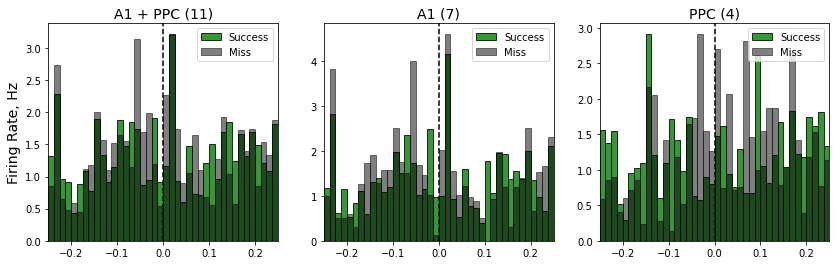

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

idxs_list = [
    list(range(len(tgt_units))),
    np.where(labels == 0)[0],
    np.where(labels == 1)[0],
]
titles = ['%s + %s' % (areas[0], areas[1]), areas[0], areas[1]]

for i, idxs in enumerate(idxs_list):
    axes[i].hist(bins[:-1], bins=bins, weights=psth_matrix_succ[idxs].sum(axis=0)/len(idxs), edgecolor='black', color='green', alpha=0.8, label='Success')
    axes[i].hist(bins[:-1], bins=bins, weights=psth_matrix_miss[idxs].sum(axis=0)/len(idxs), edgecolor='black', color='black', alpha=0.5, label='Miss')
    axes[i].axvline(0, color='black', ls='--')
    axes[i].set_xlim(-hw, hw)
    axes[i].legend(loc='upper right', prop={'size': 10})
    axes[i].set_title("%s (%d)" % (titles[i], len(idxs)), fontsize=14)

axes[0].set_ylabel("Firing Rate, Hz", fontsize=14)
        
#fig.savefig(os.path.join(report_path, 'PSTH_succ_fail_tgt_micro.pdf'))

## Across sessions

### Predict by the P1 bin

In [11]:
# A1_units = [name for name in tgt_units if int(name[0]) < 3]
# win_l, win_r = 0.013, 0.026  # P1 window, take from AEP metric lims?

# # first compute BGR firing in the P1 bin for all units
# avg_bgr_rates = np.zeros(len(A1_units))
# for i, unit_name in enumerate(A1_units):
#     spk_counts = []
#     spk_times = spike_times[unit_name]
#     for t_pulse in aeps_events[aeps_events[:, 1] == 1][:, 0]:  # all BGR pulses
#         count = len(spk_times[(spk_times > t_pulse + win_l) & (spk_times < t_pulse + win_r)])
#         spk_counts.append(count)
#     avg_bgr_rates[i] = np.array(spk_counts).mean() / (win_r - win_l)
    
# # then for each event compute population
# response = np.zeros(len(tgt_matrix))
# for i, event in enumerate(tgt_matrix):
#     # compute population response in the P1 window for each entrance event
#     counts = 0
#     t_pulse = aeps_events[event[2]][0]
    
#     for j, unit_name in enumerate(A1_units):
#         spk_times = spike_times[unit_name]
#         count = len(spk_times[(spk_times > t_pulse + win_l) & (spk_times < t_pulse + win_r)])
#         counts += count

#     response[i] = ((counts/len(A1_units))/(win_r - win_l))